In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from scipy import ndimage
import pandas as pd

from tensorflow.keras import models, layers, metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import LeakyReLU

import os

In [2]:
base_dir='../data/chest_xray/'

train_path = '../data/chest_xray/train'

validation_path = '../data/chest_xray/val'

test_path = '../data/chest_xray/test'

In [3]:
train_pneumonia=os.listdir('../data/chest_xray/train/PNEUMONIA/')
train_normal=os.listdir('../data/chest_xray/train/NORMAL/')
val_dir_normal=os.listdir('../data/chest_xray/val/NORMAL/')
test_dir_normal=os.listdir('../data/chest_xray/test/NORMAL/')
val_dir_pneumonia=os.listdir('../data/chest_xray/val/PNEUMONIA/')
test_dir_pneumonia=os.listdir('../data/chest_xray/test/PNEUMONIA/')

label_string = os.listdir('../data/chest_xray/train')

In [4]:
# Greyscale distribution histogram - done, Jamie
# Class distribution - heavily weighted towards positive class (pneumonia) - done, Jamie
# Address class imbalance - incorporate flipped 0-class images - Rachel wrote a function for this
# Mean values for negative and positive classes - Svitlana 
# Look for outliers
# Look at subracting the pixel mean
# Apply matrix transformations to further define images - 
# Data Augmentation - Svitlana will make an attempt

In [5]:
print("Train set w/ pneumonia: ", len(train_pneumonia))
print("Train set normal: ", len(train_normal))
print("Validation set w/ pneumonia: ", len(val_dir_pneumonia))
print("Validation set normal: ", len(val_dir_normal))
print("Test set w/ pneumonia: ", len(test_dir_pneumonia))
print("Test set normal: ", len(test_dir_normal))

Train set w/ pneumonia:  2144
Train set normal:  699
Validation set w/ pneumonia:  1739
Validation set normal:  650
Test set w/ pneumonia:  390
Test set normal:  234


In [6]:
2144+699, 1739+650, 390+234

(2843, 2389, 624)

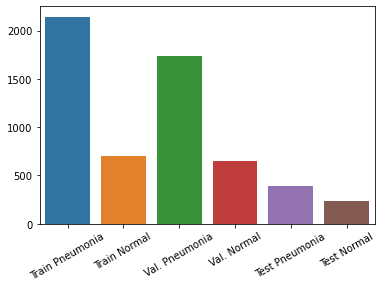

In [7]:
labels = ['Train Pneumonia', 'Train Normal', 'Val. Pneumonia', 'Val. Normal', 'Test Pneumonia', 'Test Normal']
dist = sns.barplot(x=labels, 
           y=[len(train_pneumonia), len(train_normal), len(val_dir_pneumonia), len(val_dir_normal), len(test_dir_pneumonia), len(test_dir_normal)],)

dist.set_xticklabels(labels = labels, rotation = 30);

In [8]:
#loading images for training set - pneumonia

plt.suptitle("Patients with Pneumonia")
for i in range(0,4):
    img = train_pneumonia[i]
    img = load_img(train_path+'/PNEUMONIA/'+img)
#    plt.imshow(img)
#    plt.show()

<Figure size 432x288 with 0 Axes>

In [9]:
#loading images for training set - normal

plt.suptitle("Normal Patients")
for i in range(0,4):
    img = train_normal[i]
    img = load_img(train_path+'/NORMAL/'+img)
#    plt.imshow(img)
#    plt.show()

<Figure size 432x288 with 0 Axes>

In [10]:
train_gen = ImageDataGenerator(rescale = 1/255.).flow_from_directory(train_path,
                                                 target_size=(224, 224),
                                                 batch_size=2843,
                                                 color_mode = 'grayscale',                
                                                 class_mode='binary')

val_gen = ImageDataGenerator(rescale = 1/255.).flow_from_directory(validation_path,
                                            target_size=(224, 224),
                                            shuffle=True,
                                            batch_size=2389,
                                            color_mode = 'grayscale',                      
                                            class_mode='binary')

test_gen = ImageDataGenerator(rescale = 1/255.).flow_from_directory(test_path,
                                            target_size=(224, 224),
                                            batch_size=624,
                                            color_mode = 'grayscale',                        
                                            class_mode='binary')

Found 2843 images belonging to 2 classes.
Found 2389 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [11]:
train_images, train_labels = next(train_gen)
val_images, val_labels = next(val_gen)
test_images, test_labels = next(test_gen)

In [12]:
print("Train image shape:", train_images.shape, "train label shape:", train_labels.shape)
print("Val image shape:", val_images.shape, "val label shape:", val_labels.shape)
print("Test image shape:", test_images.shape, "test label shape:", test_labels.shape)

Train image shape: (2843, 224, 224, 1) train label shape: (2843,)
Val image shape: (2389, 224, 224, 1) val label shape: (2389,)
Test image shape: (624, 224, 224, 1) test label shape: (624,)


In [13]:
train_x = train_images.reshape(train_images.shape[0], -1)
val_x = val_images.reshape(val_images.shape[0], -1)
test_x = test_images.reshape(test_images.shape[0], -1)

In [14]:
train_x.shape, val_x.shape, test_x.shape

((2843, 50176), (2389, 50176), (624, 50176))

In [15]:
train_y = np.reshape(train_labels[:], (2843,1))
val_y = np.reshape(val_labels[:], (2389,1))
test_y = np.reshape(test_labels[:], (624,1))

In [16]:
train_y.shape, val_y.shape, test_y.shape

((2843, 1), (2389, 1), (624, 1))

# FSM  
### using one hidden layer

In [17]:
np.random.seed(42)


model = models.Sequential()
model.add(layers.Dense(12, activation='relu', input_shape=(50176,)))
model.add(layers.Dense(7, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [18]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics= (['accuracy'], metrics.Recall()))

history = model.fit(train_x,
                    train_y,
                    epochs=25,
                    batch_size=32,
                    validation_data=(val_x, val_y))

Epoch 1/25
89/89 [==============================] - 1s 14ms/step - loss: 1.1343 - accuracy: 0.7471 - recall: 0.9879 - val_loss: 0.6592 - val_accuracy: 0.7279 - val_recall: 1.0000
Epoch 2/25
89/89 [==============================] - 1s 11ms/step - loss: 0.7435 - accuracy: 0.7541 - recall: 1.0000 - val_loss: 0.6306 - val_accuracy: 0.7279 - val_recall: 1.0000
Epoch 3/25
89/89 [==============================] - 1s 12ms/step - loss: 0.6053 - accuracy: 0.7541 - recall: 1.0000 - val_loss: 0.6085 - val_accuracy: 0.7279 - val_recall: 1.0000
Epoch 4/25
89/89 [==============================] - 1s 12ms/step - loss: 0.5846 - accuracy: 0.7541 - recall: 1.0000 - val_loss: 0.5933 - val_accuracy: 0.7279 - val_recall: 1.0000
Epoch 5/25
89/89 [==============================] - 1s 12ms/step - loss: 0.5683 - accuracy: 0.7541 - recall: 1.0000 - val_loss: 0.5864 - val_accuracy: 0.7279 - val_recall: 1.0000
Epoch 6/25
89/89 [==============================] - 1s 12ms/step - loss: 0.5609 - accuracy: 0.7541 - reca

# First CNN 

In [19]:
batch_size = 64
epochs = 10
num_classes = 2

In [20]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224 , 224, 1)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (4, 4), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=(['accuracy'], metrics.Recall()))

In [21]:
model.compile(optimizer = 'rmsprop', 
              loss = 'binary_crossentropy', 
              metrics = (['accuracy'], metrics.Recall()))

In [22]:
history = model.fit(train_images, train_y, epochs = epochs, batch_size = batch_size, validation_data=(val_images, val_y))

Epoch 1/10
45/45 [==============================] - 91s 2s/step - loss: 0.7825 - accuracy: 0.7249 - recall_2: 0.9086 - val_loss: 0.4171 - val_accuracy: 0.7735 - val_recall_2: 0.9954
Epoch 2/10
45/45 [==============================] - 94s 2s/step - loss: 0.2638 - accuracy: 0.8952 - recall_2: 0.9454 - val_loss: 0.3378 - val_accuracy: 0.8698 - val_recall_2: 0.9810
Epoch 3/10
45/45 [==============================] - 97s 2s/step - loss: 0.2061 - accuracy: 0.9342 - recall_2: 0.9566 - val_loss: 0.2247 - val_accuracy: 0.9125 - val_recall_2: 0.9592
Epoch 4/10
45/45 [==============================] - 95s 2s/step - loss: 0.1291 - accuracy: 0.9536 - recall_2: 0.9674 - val_loss: 0.1433 - val_accuracy: 0.9468 - val_recall_2: 0.9655
Epoch 5/10
45/45 [==============================] - 96s 2s/step - loss: 0.1106 - accuracy: 0.9571 - recall_2: 0.9701 - val_loss: 0.2087 - val_accuracy: 0.9301 - val_recall_2: 0.9845
Epoch 6/10
45/45 [==============================] - 96s 2s/step - loss: 0.1036 - accuracy:

In [23]:
results_train = model.evaluate(train_images, train_y)

89/89 [==============================] - 19s 211ms/step - loss: 0.0302 - accuracy: 0.9880 - recall_2: 0.9841


In [24]:
history.__dict__

{'validation_data': None,
 'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x1e7604859a0>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [0.7825304865837097,
   0.26379963755607605,
   0.20611079037189484,
   0.12905603647232056,
   0.1105937510728836,
   0.10356588661670685,
   0.08126889914274216,
   0.05389764904975891,
   0.0627242848277092,
   0.22620446979999542],
  'accuracy': [0.7249384522438049,
   0.8951811194419861,
   0.9342244267463684,
   0.9535701870918274,
   0.9570875763893127,
   0.9623637199401855,
   0.9697502851486206,
   0.9820612072944641,
   0.9764333367347717,
   0.9817094802856445],
  'recall_2': [0.9085820913314819,
   0.9454290866851807,
   0.9566231369972229,
   0.9673507213592529,
   0.9701492786407471,
   0.9748134613037109,
   0.9799440503120422,
   0.985541045665741,
   0.9841417670249939,
   0.986940324306488],
  'val_loss': [0.41714128851890564,
   0.3377991020679474,
   0.22467555105686188,
   0.1433

In [28]:
model_epochs = history.epoch
model_recall_train = history.history['recall_2']
model_recall_val = history.history['val_recall_2']
model_accuracy_train = history.history['accuracy']
model_accuracy_val = history.history['val_accuracy']

## Plotting Accuracy and Recall Against Epochs

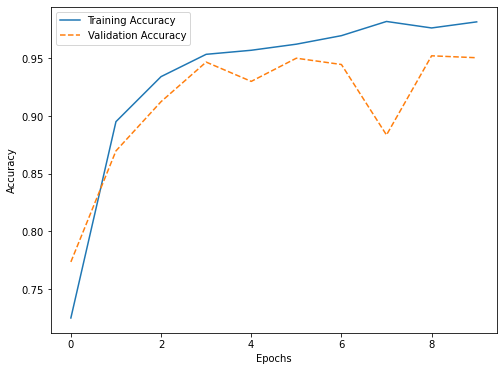

In [40]:
fig, ax = plt.subplots(figsize = (8,6))

ax.plot(model_epochs, model_accuracy_train, label = 'Training Accuracy')
ax.plot(model_epochs, model_accuracy_val, linestyle = '--', label = 'Validation Accuracy')
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
plt.legend();

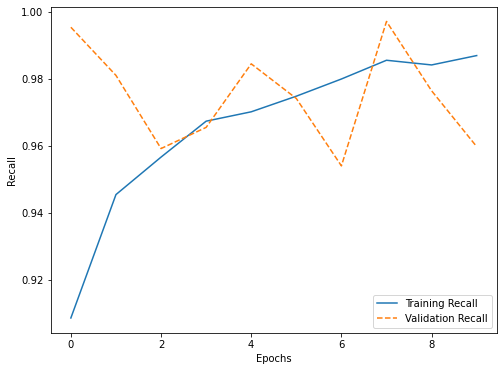

In [41]:
fig, ax = plt.subplots(figsize = (8,6))

ax.plot(model_epochs, model_recall_train, label = 'Training Recall')
ax.plot(model_epochs, model_recall_val, linestyle = '--', label = 'Validation Recall')
ax.set_xlabel("Epochs")
ax.set_ylabel("Recall")
plt.legend();